<a href="https://colab.research.google.com/github/ShawnLiu119/Segmentation_Embedding_DL/blob/main/Prototyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer2Vec Models - Prototype**

In this prototype, we focus on a basic scenario where customer event histories are generated using a simple Markov chain. We demonstrate that Word2vec and Doc2vec models capture sequential event patterns.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import random

from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.decomposition import TruncatedSVD

## Step1: generate fake data

We consider a toy model of an online apparel store that sells two categories of products, hats and dresses. Each category is represented by two products, so we have 4 products in total, 2 hats and 2 dresses. We assume two classes of customers:

-  Category shoppers come to buy either a hat or a dress. They tend to browse within one category but rarely switch between categories.
-  Look shoppers come to buy both a hat and a dress. They tend to frequently jump between the categories.<br>
Each of these two classes of shoppers is specified using a stochastic transition matrix.

In [3]:
#
# Shopper transition matrices
#

# Category shopper
transition_matrix_a = np.array([
# Hat 1 | Hat 2 | Dress 1 | Dress 2
  [0.1,    0.9,    0.0,      0.0],      # Hat 1
  [0.8,    0.1,    0.1,      0.0],      # Hat 2
  [0.0,    0.0,    0.1,      0.9],      # Dress 1
  [0.1,    0.0,    0.8,      0.1]       # Dress 2
])

# Look shoper
transition_matrix_b = np.array([
# Hat 1 | Hat 2 | Dress 1 | Dress 2
  [0.1,    0.9,    0.0,      0.0],      # Hat 1
  [0.4,    0.1,    0.5,      0.0],      # Hat 2
  [0.0,    0.0,    0.1,      0.9],      # Dress 1
  [0.5,    0.0,    0.4,      0.1]       # Dress 2
])

#
# Stationary distribution over products
#
def stationary_distribution(transition_matrix):
    P = np.transpose(transition_matrix) - np.identity(transition_matrix.shape[0])
    A = np.append(P, np.ones((1, P.shape[0])), axis=0)
    b = np.transpose(np.append(np.zeros(P.shape[0]), [1]))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))
    #Computes the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation ax = b.

print(stationary_distribution(transition_matrix_a))
print(stationary_distribution(transition_matrix_b))

[0.25 0.25 0.25 0.25]
[0.25 0.25 0.25 0.25]


In [6]:
np.transpose(transition_matrix_a)

array([[0.1, 0.8, 0. , 0.1],
       [0.9, 0.1, 0. , 0. ],
       [0. , 0.1, 0.1, 0.8],
       [0. , 0. , 0.9, 0.1]])

In [7]:
np.identity(transition_matrix_a.shape[0])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [8]:
P = np.transpose(transition_matrix_a) - np.identity(transition_matrix_a.shape[0])
P

array([[-0.9,  0.8,  0. ,  0.1],
       [ 0.9, -0.9,  0. ,  0. ],
       [ 0. ,  0.1, -0.9,  0.8],
       [ 0. ,  0. ,  0.9, -0.9]])

In [9]:
A = np.append(P, np.ones((1, P.shape[0])), axis=0)
A

array([[-0.9,  0.8,  0. ,  0.1],
       [ 0.9, -0.9,  0. ,  0. ],
       [ 0. ,  0.1, -0.9,  0.8],
       [ 0. ,  0. ,  0.9, -0.9],
       [ 1. ,  1. ,  1. ,  1. ]])

In [10]:
np.zeros(P.shape[0])

array([0., 0., 0., 0.])

In [12]:
test = np.append(np.zeros(P.shape[0]), [1])
test.shape

(5,)

In [15]:
t2 = test.reshape(1, -1)
t2.shape

(1, 5)

In [16]:
b = np.transpose(np.append(np.zeros(P.shape[0]), [1]))
b

array([0., 0., 0., 0., 1.])

In [17]:
np.transpose(A).dot(A)

array([[ 2.62, -0.53,  1.  ,  0.91],
       [-0.53,  2.46,  0.91,  1.16],
       [ 1.  ,  0.91,  2.62, -0.53],
       [ 0.91,  1.16, -0.53,  2.46]])

In [18]:
#
# Sample histories generators
#
product_names = {0: 'Hat_1', 1: 'Hat_2', 2: 'Dress_1', 3: 'Dress_2'}
def history_to_tokens(history):
    return list(map(lambda x: product_names[x], history))

def generate_user_history(transition_matrix, n_steps = 20):
    n_products = transition_matrix.shape[0]
    walk = np.random.randint(0, n_products, 1).tolist()
    for i in range(n_steps - 1): #因为已经有了walk_0, 只需要n-1 steps
        new_state = np.random.choice(n_products, 1, p=transition_matrix[walk[-1]])[0]  #p is probability with each entry,
        walk.append(new_state)
    return walk

def generate_histories(transition_matrix, n_steps = 50, n_samples = 10000):
    return [generate_user_history(transition_matrix, n_steps) for i in range(n_samples)]

history_a = generate_histories(transition_matrix_a)
history_b = generate_histories(transition_matrix_b)

all_histories = history_a + history_b #mix two types of customers
history_a_idx = range(len(history_a))
history_b_idx = range(len(history_a), len(all_histories))

In [44]:
len(all_histories)

20000

In [19]:
n_products = transition_matrix_a.shape[0]
print(n_products)

walk = np.random.randint(0, n_products, 1).tolist()
walk

4


[0]

In [20]:
np.arange(4)

array([0, 1, 2, 3])

In [24]:
transition_matrix_a.T[[1][-1]]

array([0.9, 0.1, 0. , 0. ])

In [25]:
np.random.choice(n_products, 1, p=transition_matrix_a[walk[-1]]) #在0，1，2，3里选择一个，概率按照随机customer选择四个品类的概率来

array([1])

In [26]:
np.random.choice(n_products, 1, p=transition_matrix_a[walk[-1]])[0]

1

In [31]:
history_a_arrary = np.array(history_a)
history_a_arrary.shape

(10000, 50)

### Samping make up logic

1.   transition_matrix_a代表几种客户购买偏好的随机选择（每个品类的distribution不一样），sample的时候则是随机选择某个distribution作为概率，在进行随机
2.   generate user history中n_step代表每个用户购买产品的历史，由markov chain随机决定
3.   generate histories中n_samples代表10000个随机用户的数量（每个用户假设购买50个产品（n_step=50)



(500000,)


<ipython-input-41-aaff9dcda39d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='product',
<ipython-input-41-aaff9dcda39d>:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.catplot(x='product',


(500000,)


<ipython-input-41-aaff9dcda39d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='product',
<ipython-input-41-aaff9dcda39d>:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.catplot(x='product',


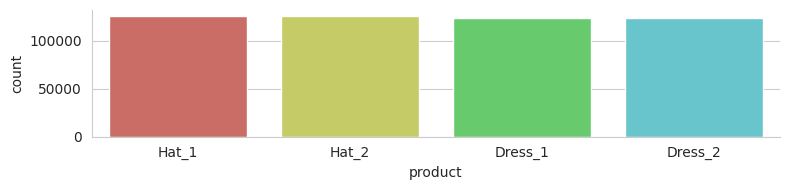

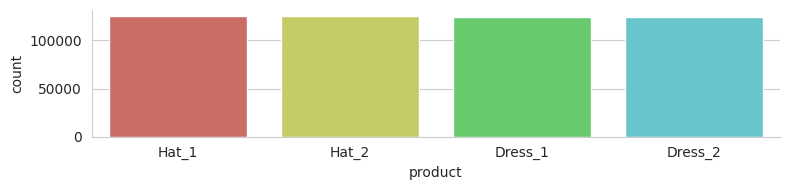

In [41]:
def plot_histogram(history):
    flat_history = np.ravel(np.array(history)) #combine all customers and all products into a 1D array
    print(flat_history.shape)
    g = sns.catplot(x='product',
            data=pd.DataFrame(history_to_tokens(flat_history), columns=['product']),
            palette=sns.color_palette("hls", 6),
            kind="count", height=2, aspect=4.0);

plot_histogram(history_a)
plot_histogram(history_b)

In [38]:
history_to_tokens(np.ravel(history_a))[0:10]

['Hat_1',
 'Hat_2',
 'Hat_1',
 'Hat_2',
 'Dress_1',
 'Dress_2',
 'Dress_1',
 'Dress_2',
 'Dress_1',
 'Dress_2']

## Step 2: Create Product Embeddings using Word2Vec

In [47]:
emdedding_size = 4
model = Word2Vec(list(map(lambda h: history_to_tokens(h), all_histories)), #map the index number to product name textual data
                 window=4,
                 vector_size=emdedding_size)

#Maximum distance between the current and predicted word within a sentence.
#each customer(sublist 50 products) can be seen as a sentence
#vector_size (int, optional) – Dimensionality of the word vectors. why we pick 4, can we pick 100?

In [66]:
#
# Product embebeddigns
#
word_vectors = model.wv
vocab = list(model.wv.key_to_index)
product2vec_dict = {arg: model.wv[arg] for arg in vocab}
embeddings = pd.DataFrame(product2vec_dict).T.values
embeddings, vocab

(array([[ 1.4457841 ,  0.6397511 ,  2.3834991 ,  1.8018233 ],
        [ 0.7888194 ,  0.02689255,  0.92220503,  3.090675  ],
        [-1.9785774 , -1.0587845 , -0.8985351 , -2.79017   ],
        [-1.7324841 ,  0.7873962 , -1.5732858 , -2.4045987 ]],
       dtype=float32),
 ['Hat_1', 'Hat_2', 'Dress_1', 'Dress_2'])

In [67]:
product2vec_dict

{'Hat_1': array([1.4457841, 0.6397511, 2.3834991, 1.8018233], dtype=float32),
 'Hat_2': array([0.7888194 , 0.02689255, 0.92220503, 3.090675  ], dtype=float32),
 'Dress_1': array([-1.9785774, -1.0587845, -0.8985351, -2.79017  ], dtype=float32),
 'Dress_2': array([-1.7324841,  0.7873962, -1.5732858, -2.4045987], dtype=float32)}

In [68]:
vocab

['Hat_1', 'Hat_2', 'Dress_1', 'Dress_2']

In [53]:
model.wv[1].shape

(4,)

## Step 3: Create Embeddings using Doc2Vec Model and Visualize

In [70]:
len(all_histories)

20000

In [71]:
documents = [ TaggedDocument(words=history_to_tokens(h), tags=[i]) for i, h in enumerate(all_histories) ] #taggedDocument (自己doc的words, doc编号) -before model trainning
doc_model = Doc2Vec(documents, vector_size = 4, window = 4, workers = 4, alpha = 0.020, epochs = 500) #每一个customer是一个doc vector

In [72]:
#
# We project and visualize a balanced subsample of customers to make sure the plot is readable.
#
samples_per_class = 2000
history_sample_idx = random.sample(history_a_idx, samples_per_class) + random.sample(history_b_idx, samples_per_class) #"+" = append，每个customer group各选2000个samples
history_true_class = ['A']*samples_per_class + ['B']*samples_per_class #label?
embeddings_sample = [doc_model.docvecs[i] for i in history_sample_idx]

<ipython-input-72-f4f0164ae86d>:7: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  embeddings_sample = [doc_model.docvecs[i] for i in history_sample_idx]


model.wv[n]中的n并不是embedding vector列的index,而是token本身key（单词，比如king)，因为这个例子只有4个token，所以model.wv[5]以5做token并不存在（dress1，dress2.。）所以会报错

In [73]:
embeddings_sample[0:5]

[array([ 1.0118885 , -0.21552293,  0.67959255,  2.2552414 ], dtype=float32),
 array([-1.9858952 , -0.498516  , -0.35031956, -1.3029864 ], dtype=float32),
 array([-0.27562636,  0.08765926,  0.07991784,  0.46663988], dtype=float32),
 array([-0.38172472, -0.06864562,  0.17842916,  0.17175184], dtype=float32),
 array([0.3465313 , 0.22599855, 0.5900072 , 1.1435678 ], dtype=float32)]

In [61]:
model.wv.index_to_key

['Hat_1', 'Hat_2', 'Dress_1', 'Dress_2']

In [74]:
len(embeddings_sample)

4000

In [63]:
model.wv['Dress_1']

array([-1.9785774, -1.0587845, -0.8985351, -2.79017  ], dtype=float32)

Truncated Singular Value Decomposition (**SVD： Singular Value Decomposition (SVD)**) is a matrix factorization technique that factors a matrix M into the three matrices U, Σ, and V. This is very similar to PCA, excepting that the factorization for SVD is done on the data matrix, whereas for PCA, the factorization is done on the covariance matrix.(降维可视化）

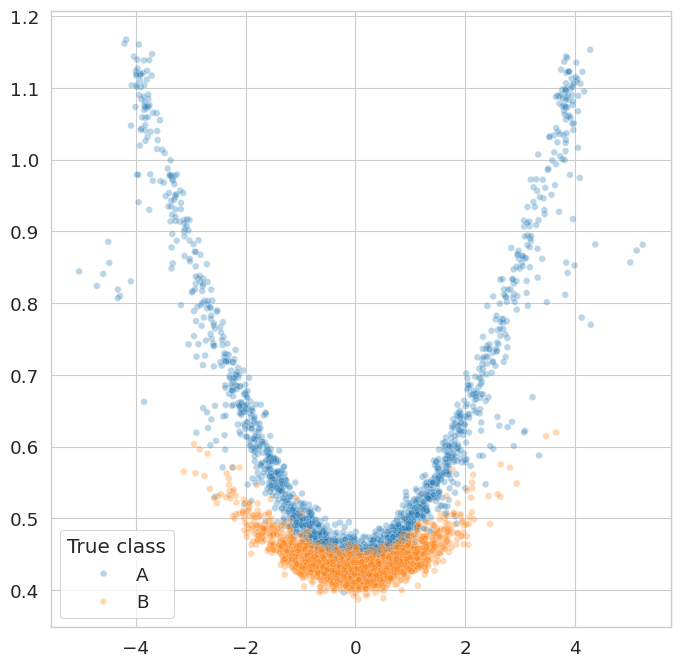

In [75]:
svd = TruncatedSVD(n_components=2)
embeddings_reduced = svd.fit_transform(embeddings_sample)

df_semantic_user = pd.DataFrame({
    'True class': history_true_class,
    'svd_2d_one': embeddings_reduced[:, 0],
    'svd_2d_two': embeddings_reduced[:, 1]
})

#
# Visualize the semantic space
#
plt.figure(figsize=(8, 8))
sns.set_context("paper", font_scale = 1.5)
sns.set_style({'font.family':'Candara', 'font.serif':['Candara']})
g = sns.scatterplot(
    x="svd_2d_one", y="svd_2d_two",
    hue='True class',
    palette=sns.color_palette(['#1f77b4', '#ff7f0e']),
    data=df_semantic_user,
    legend="full",
    alpha=0.3
)
g.set(xlabel=None)
g.set(ylabel=None)
plt.show()

## Step 5 Cluster Segementation

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from tqdm import tqdm

In [83]:
#explore
vocab_doc = list(doc_model.dv.index_to_key)
len(vocab_doc) #20000 customers in total

20000

In [84]:
doc_vector_dict = {arg:doc_model.dv[arg] for arg in vocab_doc}


In [86]:
X_doc = pd.DataFrame(doc_vector_dict).T.values
X_doc.shape

(20000, 4)

In [87]:
X_doc_subset = X_doc[history_sample_idx] # randomly sampled 4000 customers, 2000 from A, 2000 from B
X_doc_subset.shape

(4000, 4)

In [95]:
doc_vec_subset = pd.DataFrame(doc_vector_dict).T.iloc[history_sample_idx]
doc_vec_subset.shape

(4000, 4)

In [93]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc_subset)).labels_.astype(float)

silhouette_list = []
for k in tqdm(range(2, 10, 1)):
    latent_clusters = cluster_cosine(X_doc_subset, k)
    silhouette_avg = silhouette_score(X_doc_subset, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 12%|█▎        | 1/8 [00:00<00:01,  4.59it/s]

Silhouette score for 2 clusters is : 0.7816


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|██▌       | 2/8 [00:00<00:01,  4.39it/s]

Silhouette score for 3 clusters is : 0.6813


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 38%|███▊      | 3/8 [00:00<00:01,  4.01it/s]

Silhouette score for 4 clusters is : 0.6716


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 50%|█████     | 4/8 [00:00<00:01,  3.93it/s]

Silhouette score for 5 clusters is : 0.5861


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 62%|██████▎   | 5/8 [00:01<00:00,  3.73it/s]

Silhouette score for 6 clusters is : 0.5902


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 75%|███████▌  | 6/8 [00:01<00:00,  3.57it/s]

Silhouette score for 7 clusters is : 0.5596


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 88%|████████▊ | 7/8 [00:01<00:00,  3.33it/s]

Silhouette score for 8 clusters is : 0.5047


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

Silhouette score for 9 clusters is : 0.4957


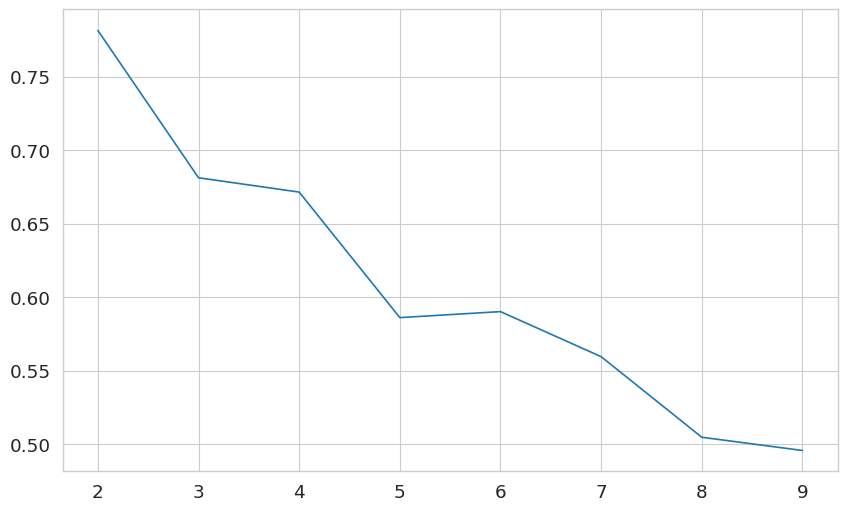

In [94]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10,1), silhouette_list)

In [97]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

distance_matrix_doc = pairwise_distances(X_doc_subset, X_doc_subset, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500, init='random') #init with pca not work
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.397s...
[t-SNE] Computed neighbors for 4000 samples in 0.673s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.001490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.598389
[t-SNE] KL divergence after 500 iterations: 1.361506


In [98]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

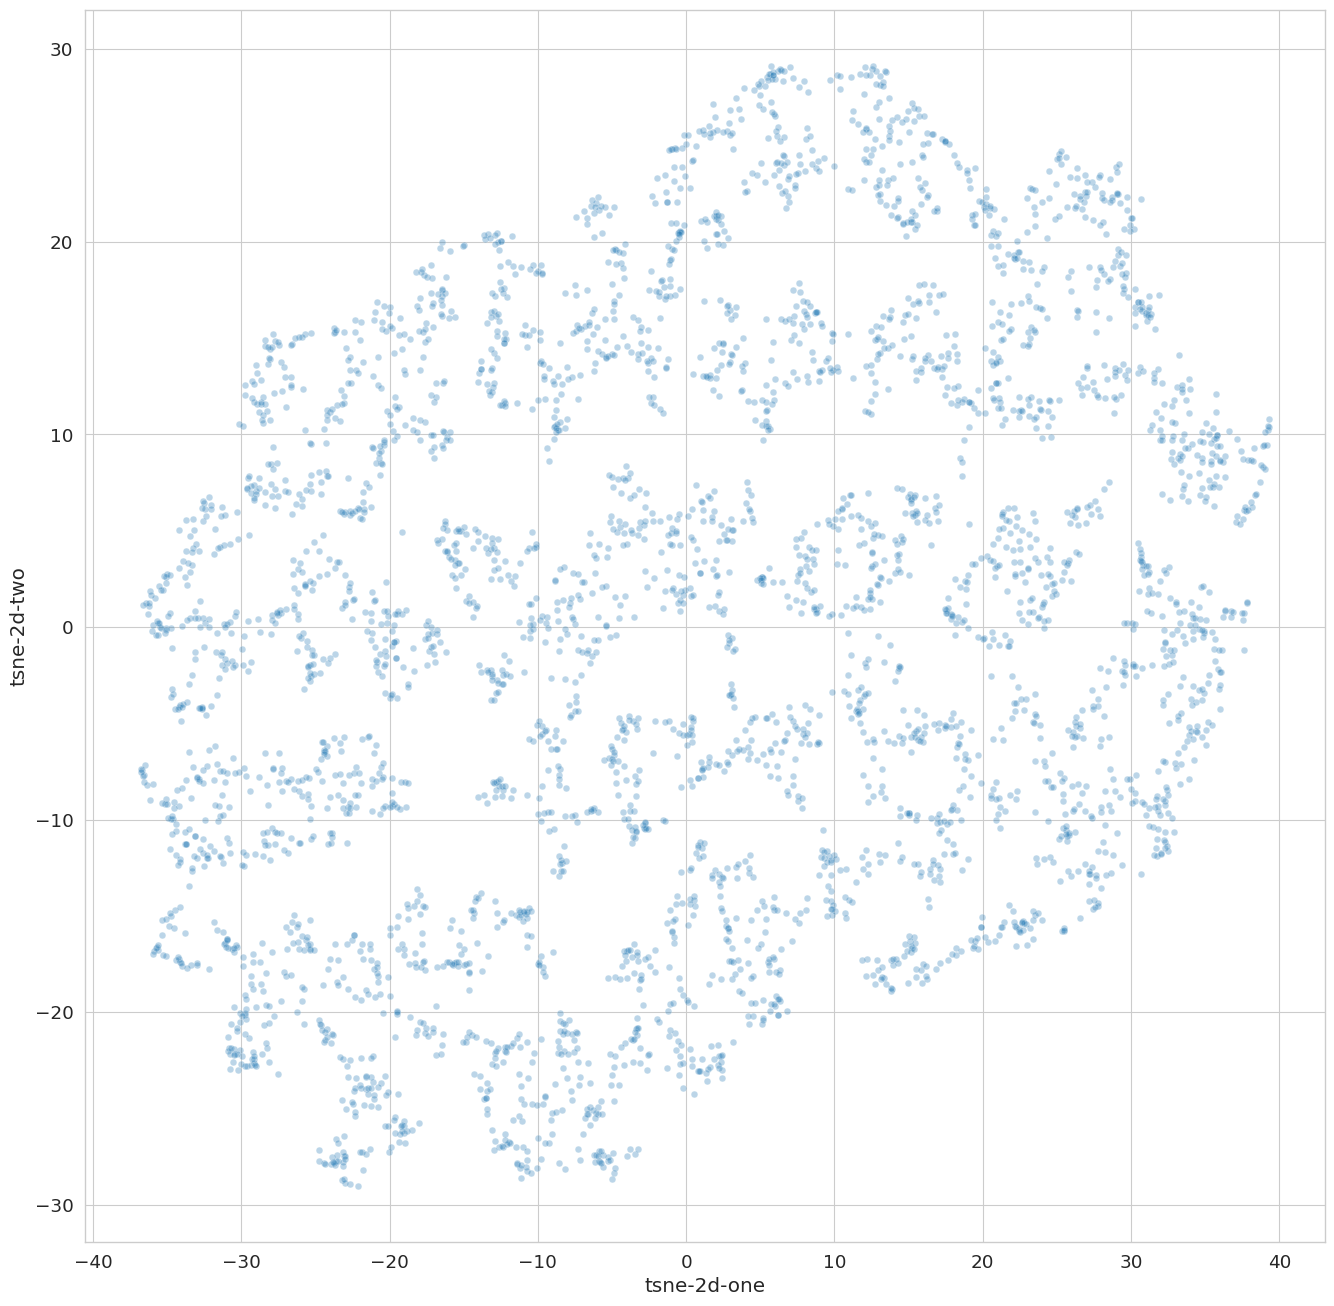

In [99]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

In [100]:
N_CLUSTER = 2

latent_clusters = cluster_cosine(X_doc_subset, N_CLUSTER)
doc_vec_end = doc_vec_subset.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


label
0.0    2010
1.0    1990
Name: count, dtype: int64

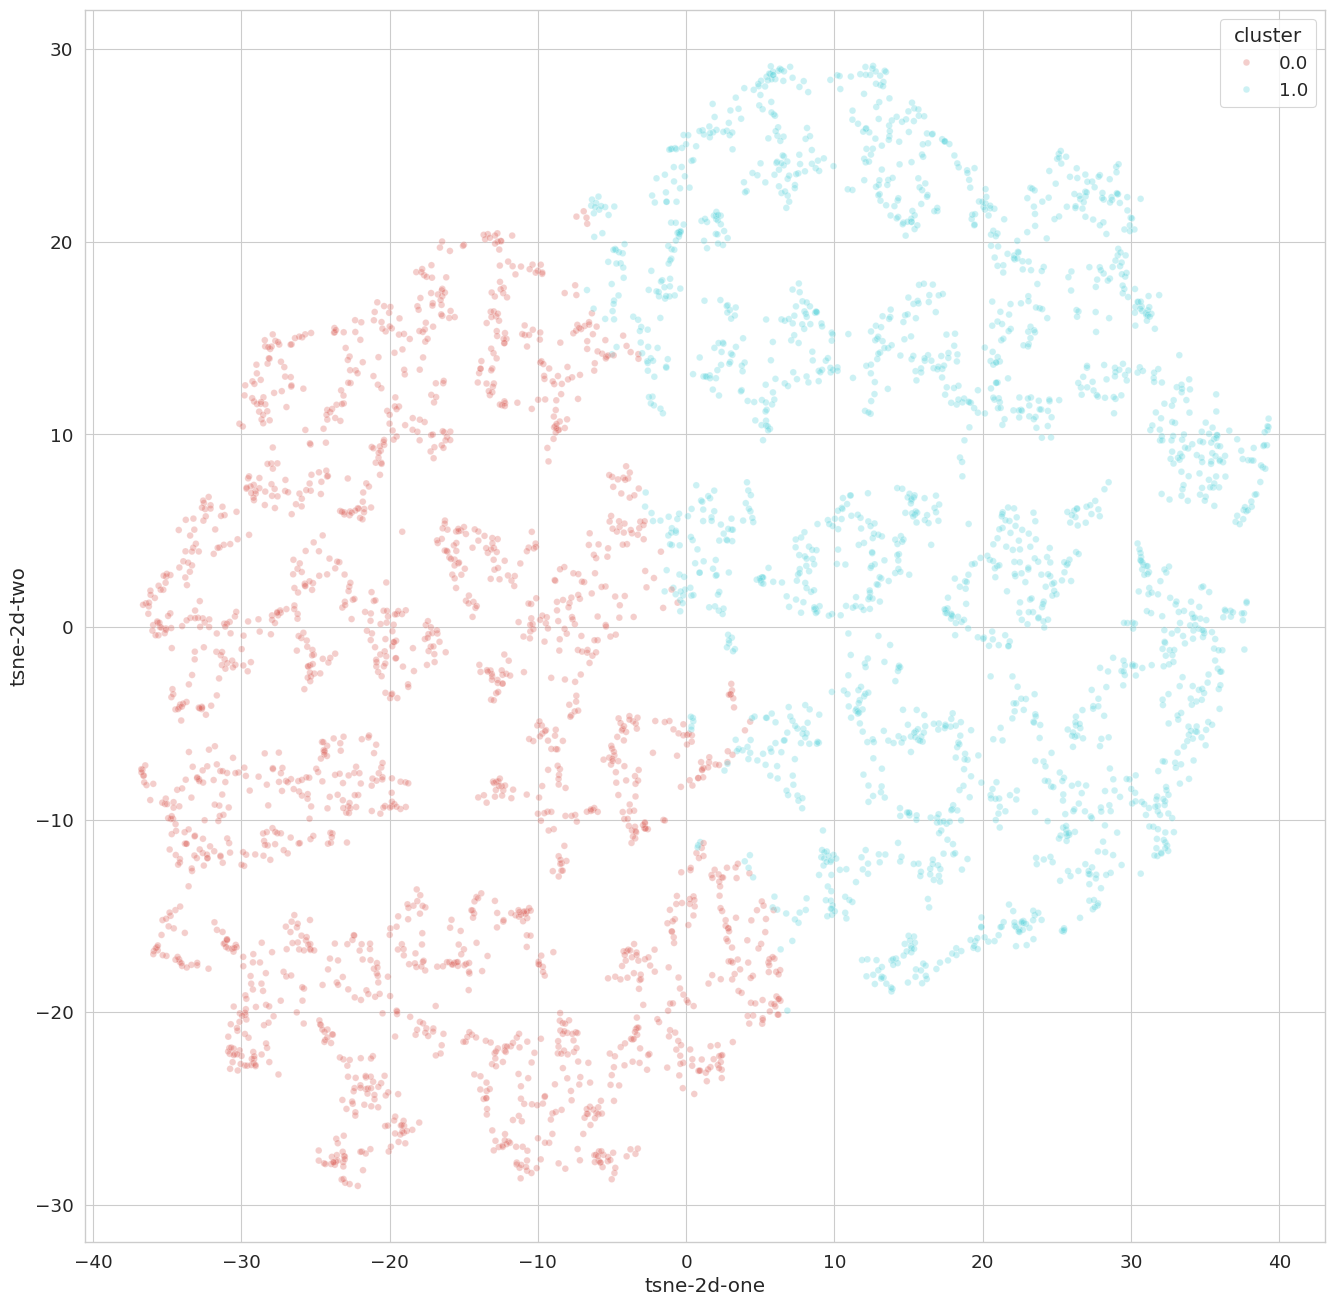

In [101]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();